In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

In [0]:
from keras.layers import Activation,Conv2D,MaxPooling2D,UpSampling2D,Dense,BatchNormalization,Input,Reshape,multiply,add,Dropout,AveragePooling2D,GlobalAveragePooling2D,concatenate
from keras.layers.convolutional import Conv2DTranspose
from keras.models import Model														  
import keras.backend as K
from keras.regularizers import l2
from keras.engine import Layer,InputSpec
from keras.utils import conv_utils
from keras.layers import Activation,Conv2D,MaxPooling2D,UpSampling2D,Dense,BatchNormalization,Input,Reshape,multiply,add,Dropout,AveragePooling2D,GlobalAveragePooling2D,concatenate
from keras.layers.convolutional import Conv2DTranspose
from keras.models import Model														  
import keras.backend as K
from keras.regularizers import l2
from keras.engine import Layer,InputSpec
from keras.utils import conv_utils
!pip install medpy
from keras.layers import *
from keras.models import Sequential
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
import keras


Using TensorFlow backend.


     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 42.5MB 72kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753451 sha256=5fa9fbd576aa5ac0a8a9cb9b6a77c3c884d86561d354717a8d0d35e959d8ee48
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


In [0]:
smooth = 1.
dropout_rate = 0.5
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [0]:
def Nest_Net(img_rows, img_cols, color_type=3, num_class=3, deep_supervision=False):

    nb_filter = [8,16,32,64,128]
    act = 'elu'
  
    bn_axis = 3
    
    
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='softmax', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='softmax', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='softmax', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='softmax', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(input=img_input, output=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(input=img_input, output=[nestnet_output_4])

    return model


In [0]:
model = Nest_Net(240,240,3)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 240, 240, 8)  224         main_input[0][0]                 
__________________________________________________________________________________________________
dp11_1 (Dropout)                (None, 240, 240, 8)  0           conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 240, 240, 8)  584         dp11_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ma..., outputs=[<tf.Tenso...)`


In [0]:
import os
import cv2
import numpy as np

In [0]:
# Function to convert image from greyscale to one hot (i.e. 3 channels)
def convertToOneHot(image):
    num_classes = 3
    shape = image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c]==0:
          encoded_image[r][c][0] = 1
        elif image[r][c]==128:
          encoded_image[r][c][1] = 1
        else:
          encoded_image[r][c][2] = 1
    return encoded_image

In [0]:
# Function to convert back from one hot image to greyscale
def convertFromOneHot(image):
    shape = image.shape[:2]
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c][0] == 1:
          encoded_image[r][c] = 0
        elif image[r][c][1] == 1:
          encoded_image[r][c] = 128
        else:
          encoded_image[r][c] = 255
    return encoded_image

In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/3 Class"

# Train set patients: 230 263 239 242 
TrainX_1 = np.load(PATH + '/ER IHC 239 Images.npy')
TrainY_1 = np.load(PATH + '/ER IHC 239 Masks.npy')
TrainX_2 = np.load(PATH + '/ER IHC 263 Images.npy')
TrainY_2 = np.load(PATH + '/ER IHC 263 Masks.npy')
TrainX_3 = np.load(PATH + '/ER IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/ER IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/ER IHC 230 Images.npy')
TrainY_4 = np.load(PATH + '/ER IHC 230 Masks.npy')

# Test set patients: 221 246 232
TestX_1 = np.load(PATH + '/ER IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/ER IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/ER IHC 246 Images.npy')
TestY_2 = np.load(PATH + '/ER IHC 246 Masks.npy')
TestX_3 = np.load(PATH + '/ER IHC 232 Images.npy')
TestY_3 = np.load(PATH + '/ER IHC 232 Masks.npy')

In [0]:
np.unique(TestY_3)


array([  0., 128., 255.])

In [0]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGroundTruth = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = []

for img in TrainGroundTruth:
  encoded_img = convertToOneHot(img)
  TrainY.append(encoded_img)

TrainY = np.asarray(TrainY)

TestX = np.concatenate((TestX_1, TestX_2, TestX_3), axis=0)
TestGroundTruth = np.concatenate((TestY_1, TestY_2, TestY_3), axis=0)
TestY = []

for img in TestGroundTruth:
  encoded_img = convertToOneHot(img)
  TestY.append(encoded_img)

TestY = np.asarray(TestY)

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)
np.unique(TestY)

(1800, 240, 240, 3)
(1800, 240, 240, 3)
(1440, 240, 240, 3)
(1440, 240, 240, 3)
(120, 240, 240, 3)
(120, 240, 240, 3)


array([0, 1], dtype=uint8)

In [0]:
TrainX = np.reshape(TrainX,(-1,240, 240,3))
TrainY = np.reshape(TrainY,(-1,240, 240,3))

TrainX = TrainX.astype('float32')/255

TestX = np.reshape(TestX,(-1,240, 240,3))
TestY = np.reshape(TestY,(-1,240, 240,3))

TestX = TestX.astype('float32')/255

ValidX = np.reshape(ValidX,(-1,240, 240,3))
ValidY = np.reshape(ValidY,(-1,240, 240,3))

ValidX = ValidX.astype('float32')/255

In [0]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

np.unique(TestY)

(1800, 240, 240, 3)
(1800, 240, 240, 3)
(1440, 240, 240, 3)
(1440, 240, 240, 3)
(120, 240, 240, 3)
(120, 240, 240, 3)


array([0, 1], dtype=uint8)

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
  
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    return 1 - score

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))+(dice_loss(y_true, y_pred))

def loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))










In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.0001, decay=0.0, amsgrad=True)

In [0]:
model.compile(loss=combined_loss, optimizer=optimizer, metrics=[dice_coef,'accuracy',tversky_loss, loss, combined_loss])

In [0]:
TrainY.shape

(1800, 240, 240, 3)

In [0]:
num_epoch = 100;
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
history = model.fit(TrainX, TrainY, epochs=num_epoch, validation_data=(ValidX, ValidY), shuffle=True,batch_size=16,callbacks=[es,mc])
model.save(MODELS_PATH + '/NestedUNET_ER_20_03_19_dice.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1800 samples, validate on 120 samples
Epoch 1/100





1800/1800 [==============================] - 36s 20ms/step - loss: 1.5642 - dice_coef: 0.7656 - acc: 0.7810 - tversky_loss: 1.6641 - loss_1: 1.1657 - combined_loss: 1.4001 - val_loss: 0.2451 - val_dice_coef: 0.9877 - val_acc: 0.9884 - val_tversky_loss: 1.9529 - val_loss_1: 0.0890 - val_combined_loss: 0.1013

Epoch 00001: val_loss improved from inf to 0.24506, saving model to Checkpoint.h5
Epoch 2/100
1800/1800 [==============================] - 17s 9ms/step - loss: 0.7337 - dice_coef: 0.8506 - acc: 0.8708 - tversky_loss: 1.3970 - loss_1: 0.4573 - combined_loss: 0.6067 - val_loss: 0.3565 - val_dice_coef: 0.9228 - val_acc: 0.9823 - val_tversky_loss: 1.9410 - val_loss_1: 0.1673 - val_combined_loss: 0.2445

Epoch 00002: val_loss did not improve from 0.24506
Epoch 3/100
1800/1800 [==============================] - 17s 9ms/step - los

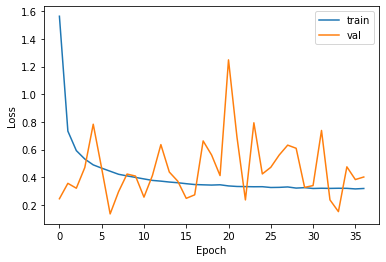

In [0]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

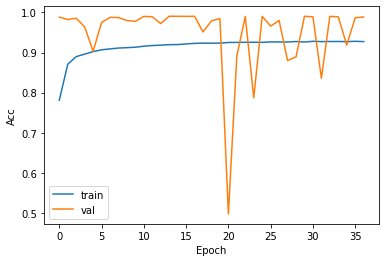

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [0]:
# MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
# model = keras.models.load_model(MODELS_PATH+'/UNET_ER_20_03_03_v5.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [0]:
# Function to find the most probable class of an image pixel by pixel
def ClassFinder(img):
  result = np.zeros(img.shape, dtype=np.uint8)
  for r in range(len(img)):
    for c in range(len(img[0])):
      idx = np.argmax(img[r][c])
      result[r][c][idx]=1
      
  return result    

In [0]:
train_result = model.predict(TrainX, batch_size=16)
print(np.shape(train_result))
Train_predict = [ ]
for img in train_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_predict.append(encoded_img)

Predicted_images = np.asarray(Train_predict)
print(Predicted_images.shape)
np.unique(Predicted_images)
# dice = dc(train_result, TrainY)
# pre  = precision(train_result,TrainY)
# re   = recall(train_result,TrainY)
# print('Train dc: '  + str(dice))
# print('Train pre: ' + str(pre))
# print('Train re: '  + str(re))

(1800, 240, 240, 3)
(1800, 240, 240)


array([  0, 128, 255], dtype=uint8)

In [0]:
test_result = model.predict(TestX, batch_size=16)
print(np.shape(test_result))

Test_predict = [ ]
for img in test_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_predict.append(encoded_img)

Predicted_images_test = np.asarray(Test_predict)
print(Predicted_images_test.shape)
np.unique(Predicted_images_test)
# dice = dc(test_result, TestY)
# pre  = precision(test_result,TestY)
# re   = recall(test_result,TestY)
# print('Test dc: '  + str(dice))
# print('Test pre: ' + str(pre))
# print('Test re: '  + str(re))

(1440, 240, 240, 3)
(1440, 240, 240)


array([  0, 128, 255], dtype=uint8)

In [0]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(Actual, Predicted):
  ActualY = np.reshape(Actual,(-1, Actual.shape[3]))
  PredY = np.reshape(Predicted,(-1, Predicted.shape[3]))
  matrix = confusion_matrix(ActualY.argmax(axis = 1), PredY.argmax(axis = 1))
  return matrix

def get_precision(confusion_matrix):
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
  nan_indices = np.isnan(precision)
  precision[nan_indices] = 0
  return precision

def get_recall(confusion_matrix):
  recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
  nan_indices = np.isnan(recall)
  recall[nan_indices] = 0
  return recall


In [0]:
test_matrix = get_confusion_matrix(TestY, test_result)
train_matrix = get_confusion_matrix(TrainY, train_result)
print(test_matrix)
print(train_matrix)
# TestY.shape[3]
# test_result.shape

[[75820459   674167    71899]
 [  790416  2554797    16077]
 [  263793  1522238  1230154]]
[[85332681  2405528  1227204]
 [  920014  3458642  1344259]
 [  669121   978722  7343829]]


In [0]:
np.unique(Predicted_images_test)

array([  0, 128, 255], dtype=uint8)

In [0]:
test_precision = get_precision(test_matrix)
print('Test Precision')
print(test_precision)
test_recall = get_recall(test_matrix)
print('Test Recall')
print(test_recall)
train_precision = get_precision(train_matrix)
print('Train Precision')
print(train_precision)
train_recall = get_recall(train_matrix)
print('Train Recall')
print(train_recall)

Test Precision
[0.98628665 0.53771593 0.93325696]
Test Recall
[0.99025598 0.76006444 0.40785098]
Train Precision
[0.98171765 0.50543571 0.74065686]
Train Recall
[0.95916692 0.60434971 0.81673675]


In [0]:
# weight_matrix = np.zeros((3,1))
# weight_matrix[0] = 0.6
# weight_matrix[1] = 0.2
# weight_matrix[2] = 0.2
# print(weight_matrix.shape)

In [0]:
weight_matrix = np.zeros((3,1))
weight_matrix[0] = 1/3
weight_matrix[1] = 1/3
weight_matrix[2] = 1/3
print(weight_matrix.shape)

(3, 1)


In [0]:
def get_overall_precision(precision, weights):
  final_precision = np.dot(precision,weights)
  return final_precision

def get_overall_recall(recall, weights):
  final_recall = np.dot(recall ,weights)
  return final_recall

In [0]:
final_test_precision  = get_overall_precision(test_precision, weight_matrix)
final_test_recall     = get_overall_recall(test_recall, weight_matrix)
final_train_precision = get_overall_precision(train_precision, weight_matrix)
final_train_recall    = get_overall_recall(train_recall, weight_matrix)
print('Final Test Precision')
print(final_test_precision)
print('Final Test Recall')
print(final_test_recall)
print('Final Train Precision')
print(final_train_precision)
print('Final Train Recall')
print(final_train_recall)

Final Test Precision
[0.81908652]
Final Test Recall
[0.71939046]
Final Train Precision
[0.74260341]
Final Train Recall
[0.79341779]


In [0]:
from scipy.stats import hmean

def dice_coefficient(precision, recall):
  return hmean(np.asarray([precision , recall]))
  

In [0]:
test_dice_coeff = dice_coefficient(final_test_precision, final_test_recall)
print('Test Dice coeff')
print(test_dice_coeff)

train_dice_coeff = dice_coefficient(final_train_precision, final_train_recall)
print('Train Dice coeff')
print(train_dice_coeff)

Test Dice coeff
[0.76600825]
Train Dice coeff
[0.76717008]


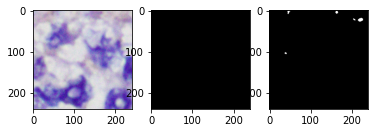

In [0]:
copy1  = np.copy(TestX [250])
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
copy3 = np.reshape(copy2,(240, 240,3))
Img = cv2.cvtColor(copy3,cv2.COLOR_BGR2RGB)

Mask = TestGroundTruth[250]

Predicted_Mask = Predicted_images_test[250] 

plt.subplot(131).imshow(Img)
plt.subplot(132).imshow(Mask,'gray')
plt.subplot(133).imshow(Predicted_Mask,'gray')

In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img


In [0]:
def saveNumpyOutput(mask):
  num = mask.shape[0]/480
  for id in range(int(num)):
    temp = []
    for i in range(id, id+10):
      idx = i * 48
      final_output = mask[idx:idx+48]
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/Combined_Loss/ER1 Patient " + str(id), final_output)

In [0]:
# saving predicted outputs as numpy arrays for test images
saveNumpyOutput(Predicted_images)

(48, 240, 240, 3)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0. 128. 255.]


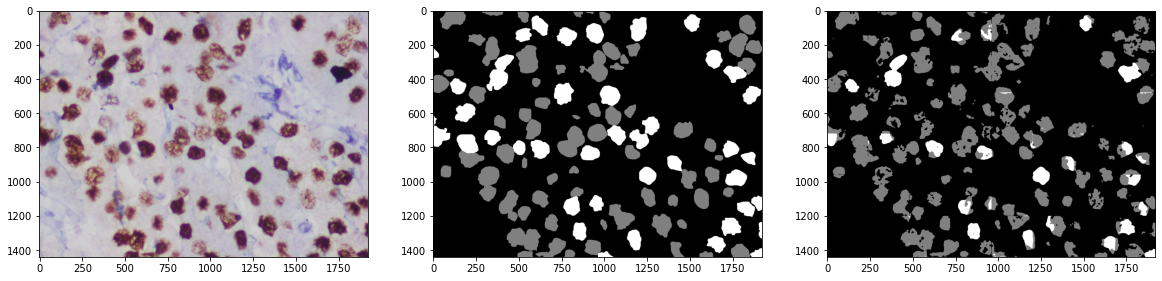

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 24   # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]

Mask_input = TestY[id:id+48]
Test_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Test_Actual)
print(Mask_input.shape)

final_output = Predicted_images_test[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')



(48, 240, 240, 3)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0. 128. 255.]


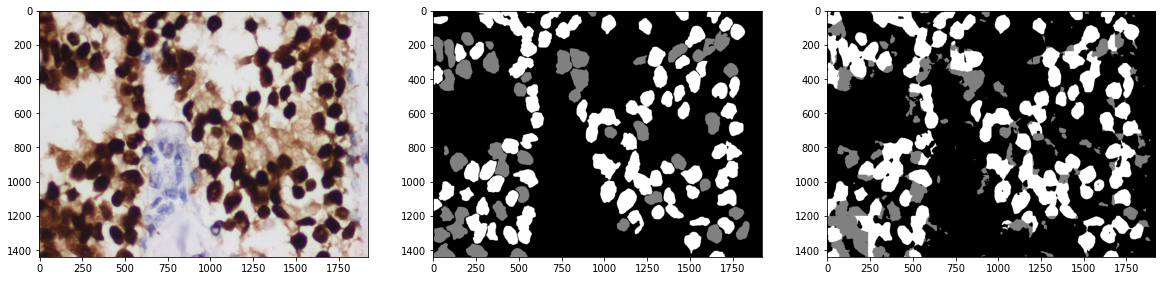

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 11  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = TrainY[id:id+48]
Train_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Train_Actual)
print(Mask_input.shape)

final_output = Predicted_images[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')
